# Midterm (MACS 30100), February 5, 2018
### Joseph Denby
You will have an hour and thirty minutes to take this exam.
1. Put your name in the space provided above (without the brackets).
2. Download this notebook and accompanying data `LenderDataLong.dta`.
3. The class will disconnect their wi-fi and begin taking the exam.
4. The exam is open computer, closed internet, open note.
5. Once you are done, you will signal to a TA or instructor to come over and monitor while you reconnect to the internet and upload your edited notebook to Canvas.

Remember that you must clearly indicate your answers to all questions below. We will give partial credit for partially correct answers. The midterm is worth 20 points (2 problem sets).

## The data
This two exercises of this midterm and all their respective subparts will use the `LenderData.csv` dataset, which contains observations of characteristics on short-term, high interest rate, lender information. You are not to use this data outside of this class. It is a jittered and randomized version of a dataset used in a published research paper.

Each observation contains characteristics of a particular lender location Read it into Python using the `pandas.read_csv()` command. The variables are the following:

* `avgrate`: average annualized interest rate of all loans in percentage points (235 = two hundred and thirty five percent)
* `numstores`: number of other stores owned by the same owner (measure of size)
* `defrate`: default rate on loans from that store during 2010
* `pdrad3`: number of payday lenders within a three-mile radius of the store (measure of competition)
* `pnrad3`: number of pawn lenders within a three-mile radius of the store (measure of competition)
* `totrad3`: total number of other lenders within a three-mile radius of the store (measure of competition)
* `unrt_zip`: unemployment rate in the zip code of the store
* `medtotinc2010`: median total household income in the zip code of the store
* `edbachplus_zip`: average education level in years of schooling of heads of household in the zip code of the store
* `pop_zip`: population in zip code of the store
* `mdage_zip`: median age (in years) in zip code of the store
* `pctblk2_zip`: percent of the population that is black in the zip code of the store in percentage points (2.2=two point two percent)

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.optimize as opt
import scipy.stats as sts
import statsmodels.api as sm
%matplotlib notebook

In [2]:
lenders = pd.read_csv('LenderData.csv')
# Read in the data

In [3]:
lenders[:5]

,avgrate,numstores,defrate,pdrad3,pnrad3,totrad3,unrt_zip,medtotinc2010,edbachplus_zip,pop_zip,mdage_zip,pctblk2_zip
0,521.429993,23,24.390244,7,3,12,5.7,38485.44531,40.2,44821,33.6,1.0
1,521.429993,23,38.596489,15,2,18,7.1,31289.11133,14.1,68295,29.2,2.2
2,521.429993,23,38.954868,6,3,11,7.1,31289.11133,14.1,68295,29.2,2.2
3,521.429993,23,27.352297,28,29,58,9.2,31421.22266,11.3,26524,28.5,1.4
4,521.429993,23,30.055660,22,17,42,7.5,27502.00000,22.3,28936,30.8,2.7



## 1. Using the distributions of interest rates and median income (10 points)

1A) [2 points] Create a plot of the histogram of high interest rate lenders interest rates `avgrate`. Use 30 bins. Make sure to label your axes and give the figure a title. If you had to group lenders into $N$ categories, how many categories would you choose based on the interest rate data? That is, how many groupings to you see in these data?

<IPython.core.display.Javascript object>


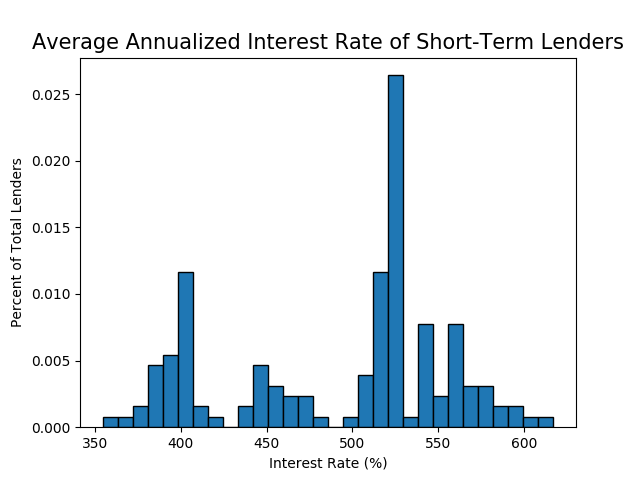

Text(0,0.5,'Percent of Total Lenders')

In [32]:
plt.hist(lenders['avgrate'], 30, edgecolor='black', normed=True)
plt.title('Average Annualized Interest Rate of Short-Term Lenders', fontsize=15)
plt.xlabel('Interest Rate (%)')
plt.ylabel('Percent of Total Lenders')


I would group these lenders into roughly three categories. I see groupings between (roughly) 350% and 425%, between 425% and 480%, and between 480% and 625%.

1B) [1 point] Create a plot of the histogram of median total household income `medtotinc2010`. Use 30 bins. Make sure to label your axes and give the figure a title.

<IPython.core.display.Javascript object>


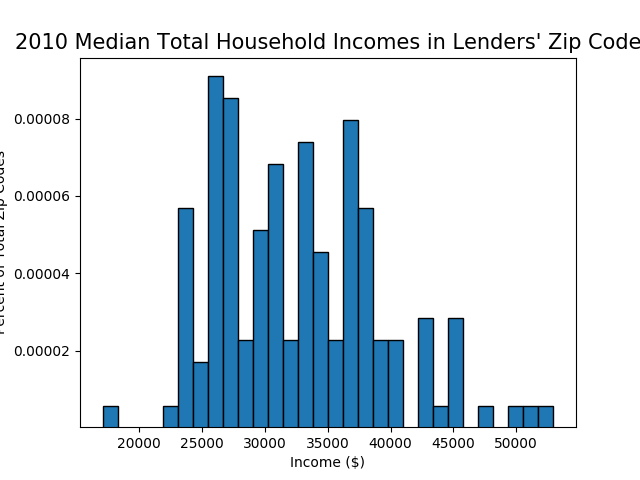

Text(0,0.5,'Percent of Total Zip Codes')

In [11]:
plt.hist(lenders['medtotinc2010'], 30, edgecolor='black', normed=True)
plt.title('2010 Median Total Household Incomes in Lenders\' Zip Code', fontsize=15)
plt.xlabel('Income ($)')
plt.ylabel('Percent of Total Zip Codes')


1C) [5 points] Use maximum likelihood estimation to fit a lognormal distribution $LN(\mu, \sigma)$ to the median income data `medtotinc2010`. Report your estimated $\hat{\mu}_{mle}$ and $\hat{\sigma}_{mle}$ as well as the likelihood function value at the maximum (not the negative log likelihood). Report your estimate of the variance-covariance matrix of your maximum likelihood estimates of $\hat{\mu}_{mle}$ and $\hat{\sigma}_{mle}$. Report the standard error on the estimate for $\hat{\mu}_{mle}$.

First, here is a function that computes pdf values for a given x-value dataset, based on a given $\mu$ and $\sigma$ lognormal parameterization.

In [13]:
def lognormpdf(x, mu, sigma):
    pdfvals = (1/(x*sigma*np.sqrt(2*np.pi)))*np.exp(-1 * (((np.log(x)-mu)**2)/(2*(sigma**2))))
    return pdfvals

Now, here is a function that uses the above function to return a log likelihood value for a dataset under a specified lognormal parameterization.

In [12]:
def log_lik_lognorm(xvals, mu, sigma):
    pdfvals = lognormpdf(xvals, mu, sigma)
    ln_pdf_vals = np.log(pdfvals)
    log_lik_val = ln_pdf_vals.sum()
    return log_lik_val

Finally, here is a criterion function that will feed into the optimization function to minimize the negative log likelihood value in order to determine the best parameterization of the lognormal distribution for the specified dataset.

In [14]:
def log_norm_criterion(params, xvals):
    mu, sigma = params
    loglik = log_lik_lognorm(xvals, mu, sigma)
    return -loglik

Now I can use the `opt.minimize()` function.

In [112]:
mu_init = 10
sigma_init = 1
params_init = np.array([mu_init, sigma_init])
mle_args = lenders['medtotinc2010']
results = opt.minimize(log_norm_criterion, params_init, args = mle_args)
mu_MLE, sig_MLE = results.x
print('Optimal mu =', mu_MLE, 'Optimal sigma =', sig_MLE)
print('Optimal log-likelihood = ', log_lik_lognorm(lenders['medtotinc2010'], mu_MLE, sig_MLE))

Optimal mu = 10.377380207796609 Optimal sigma = 0.19949929628254223
Optimal log-likelihood =  -1497.103008886208


To get the VCV matrix and standard error for $\hat{\mu}_{MLE}$:

In [113]:
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv * OffDiagNeg
stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = \n', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)


VCV(MLE) = 
 [[ 2.85966902e-04 -2.76553583e-06]
 [-2.76553583e-06  1.35757932e-04]]
Standard error for mu estimate =  0.016910555938492427


1D) [2 points] Plot the predicted distribution from your maximum likelihood estimates $\hat{\mu}_{mle}$ and $\hat{\sigma}_{mle}$ against the histogram of the data.

<IPython.core.display.Javascript object>


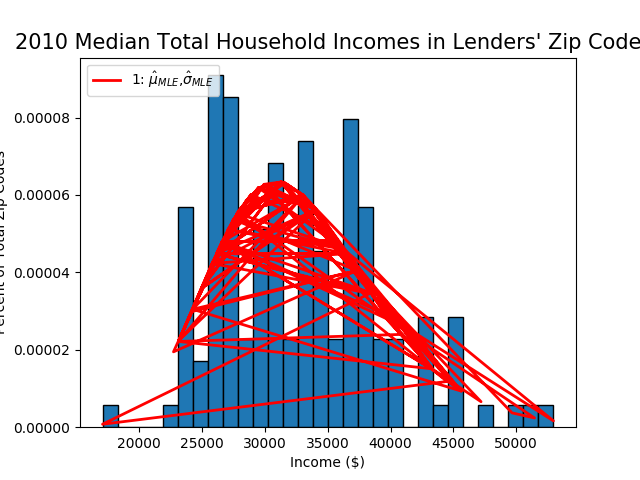

In [114]:
plt.hist(lenders['medtotinc2010'], 30, edgecolor='black', normed=True)
plt.title('2010 Median Total Household Incomes in Lenders\' Zip Code', fontsize=15)
plt.xlabel('Income ($)')
plt.ylabel('Percent of Total Zip Codes')

plt.plot(lenders['medtotinc2010'], lognormpdf(lenders['medtotinc2010'], mu_MLE, sig_MLE),
         linewidth=2, color='r', label='1: $\hat{\mu}_{MLE}$,$\hat{\sigma}_{MLE}$')
plt.legend(loc='upper left')

Weird plotting error – probably need to reorder the pdf values created by the above function. Also, got majorly different answers depending on initial values – I just pushed them around until the plot showed something somewhat legitimate.

## 2. Determinants of lender interest rates (10 points)

2A) [3 points] Assume a simple regression model of four factors that influence the interest rates that a lender charges, namely, number of stores, default rate in the area, unemployment rate in the area, and median household income in the area.

$$ avgrate_i = \beta_0 + \beta_1 numstores_i + \beta_2 defrate_i + \beta_3 unrt_zip_i + \beta_4 medtotinc2010_i + u_i $$

Estimate this model by OLS using the `statsmodels.api` package. Don't forget to include a constant. Print your results summary. Which variables are significant at the 5-percent level? How would you interpret in words the estimated coefficient on `numstores`?

In [99]:
lenders['const'] = 1

In [100]:
lenders_reg = sm.OLS(endog=lenders['avgrate'], exog=lenders[['const','numstores', 'defrate', 'unrt_zip', 'medtotinc2010']], missing='drop')
results = lenders_reg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                avgrate   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     4.375
Date:                Mon, 05 Feb 2018   Prob (F-statistic):            0.00229
Time:                        12:43:09   Log-Likelihood:                -812.28
No. Observations:                 147   AIC:                             1635.
Df Residuals:                     142   BIC:                             1650.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           453.4117     51.263      8.845

At the 5% significance level, solely the coefficient for $numstores_i$ is significant. Based on this output, one can interpret the coefficient as indicating that, all other variables held equal, a lender owning one more store is associated with a 2.6278 percent decrease in their average annualized loan interest rate.

2B) [4 points] Now assume a richer model for the determinants of lender interest rates, which includes the following measures of competition and other demographic variables.

$$ avgrate_i = \beta_0 + \beta_1 numstores_i + \beta_2 defrate_i + \beta_3 unrt_zip_i + \beta_4 medtotinc2010_i + ... $$
$$ \qquad\qquad\qquad\qquad \beta_5 totrad3_i + \beta_6 edbachplus\_zip_i + \beta_7 pop\_zip_i + \beta_8 mdage\_zip_i + \beta_9 pctblk2\_zip_i + u_i $$

Estimate this regression by OLS using the `statsmodels.api` package. In controlling for these new varaibles, do any of the originally estimated coefficients from the model in part (2A) become statistically not significant (at the 5 percent level)? Of these new coefficients ($\beta_5$ through $\beta_9$), which one(s) are the most statistically significant?

In [101]:
lenders_reg = sm.OLS(endog=lenders['avgrate'], exog=lenders[['const','numstores', 'defrate', 'unrt_zip', 'medtotinc2010', 'totrad3', 'edbachplus_zip', 'pop_zip', 'mdage_zip', 'pctblk2_zip']], missing='drop')
results = lenders_reg.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                avgrate   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     2.846
Date:                Mon, 05 Feb 2018   Prob (F-statistic):            0.00419
Time:                        12:43:25   Log-Likelihood:                -808.23
No. Observations:                 147   AIC:                             1636.
Df Residuals:                     137   BIC:                             1666.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            613.9741     85.491      7.

Based on the output of this model, as compared to that of the previous model, none of the originally specified regressor variables changed drastically in statistical significance. The $numstores$ variable is still significant at the 5% level, while the other originally specified variables still aren't. Of the *new* variables, the coefficient for $edbachplus\_zip$ is significant at the 5% level, but none of the other variables are.

2C) [3 points] Create a new binary variable called `avgrate_high` that equals 1 if `avgrate` > 490, and equals 0 otherwise. Estimate a logistic regression using the `statsmodels.api` package. Let $X\beta$ be the linear coefficients and variables from the model from part (2B).

$$ Pr(avgrate\_high=1|X\beta) = \frac{X\beta}{1 + X\beta} $$

Report the variables whose coefficients are estimated to be significant at the 5-percent level.

In [107]:
lenders["avgrate_high"] = lenders['avgrate'].apply(lambda x: int(x >= 425))

In [108]:
lenders[:5]

,avgrate,numstores,defrate,pdrad3,pnrad3,totrad3,unrt_zip,medtotinc2010,edbachplus_zip,pop_zip,mdage_zip,pctblk2_zip,const,avgrate_high
0,521.429993,23,24.390244,7,3,12,5.7,38485.44531,40.2,44821,33.6,1.0,1,1
1,521.429993,23,38.596489,15,2,18,7.1,31289.11133,14.1,68295,29.2,2.2,1,1
2,521.429993,23,38.954868,6,3,11,7.1,31289.11133,14.1,68295,29.2,2.2,1,1
3,521.429993,23,27.352297,28,29,58,9.2,31421.22266,11.3,26524,28.5,1.4,1,1
4,521.429993,23,30.055660,22,17,42,7.5,27502.00000,22.3,28936,30.8,2.7,1,1


I was getting a strange error about a missing function deep within the summary call (same as in my PS4), so I am copying this lambda function from that problem set as a workaround.

In [109]:
scipy.stats.chisqprob = lambda chisq, df: scipy.stats.chi2.sf(chisq, df)

In [110]:
LogitModel = sm.Logit(endog=lenders['avgrate_high'], exog=lenders[['const','numstores', 'defrate', 'unrt_zip', 'medtotinc2010', 'edbachplus_zip', 'pop_zip', 'mdage_zip', 'pctblk2_zip']], missing='drop')
LogitReg_sm = LogitModel.fit()
print(LogitReg_sm.summary())

Optimization terminated successfully.
         Current function value: 0.324112
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           avgrate_high   No. Observations:                  147
Model:                          Logit   Df Residuals:                      138
Method:                           MLE   Df Model:                            8
Date:                Mon, 05 Feb 2018   Pseudo R-squ.:                  0.4095
Time:                        12:46:36   Log-Likelihood:                -47.644
converged:                       True   LL-Null:                       -80.685
                                        LLR p-value:                 2.950e-11
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.2300      4.933      1.668      0.095      -1.439      17.899
numstores        

Based on the model estimation's output, $defrate$ and $numstores$ are the only variables that have coefficients significant at the 5% level.